# Project: Geometric Brownian Motion (GBM) Models and Stylized Facts
Geometric Brownian motion (GBM) is widely used as a pricing model. However, whether GBM replicates many of the statistical properties of actual pricing and return data is unclear. 
* These properties, referred to as _stylized facts_ have been observed for decades, dating back to early work by [Mandelbrot](https://en.wikipedia.org/wiki/Benoit_Mandelbrot) and later in several studies by [Rama Cont](http://rama.cont.perso.math.cnrs.fr/pdf/empirical.pdf) and more recently by [Ratliff-Crain et al.](https://arxiv.org/abs/2311.07738) who reviewed the 11 original stylized facts proposed by [Cont](http://rama.cont.perso.math.cnrs.fr/pdf/empirical.pdf) with newer data.

## Learning objectives
In this project, students will examine a few of the statistical properties (stylized facts) of return data and explore how well geometric Brownian motion models replicate these properties. 

* __Prerequisite__: Load and clean the historical dataset. The data we'll explore is daily open-high-low-close values for firms in the [S&P500 index](https://en.wikipedia.org/wiki/S%26P_500) between `01-03-2018` and `12-29-2023`.
* __Task 1__: Does geometric Brownian motion replicate common stylized facts?
    * `TODO`: Compute the return distribution predicted by a GBM model analytical solution and Monte Carlo simulation
        * `Check`: Are the analytical and Monte Carlo returns drawn from the same distribution?
        * `Discussion`: how do our choices influence the results of comparison between analytical and numerical simulation of the returns?
    * `TODO`: Test the autocorrelation of GBM model returns and the returns computed from observed market prices

## Setup
We set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions we will use in the exercise, and custom types to model the components of our example problem.
* See the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl) for additional information on functions and types used in this material.

In [3]:
include("Include.jl");

## Prerequisites: Load and clean the historical dataset
We gathered a daily open-high-low-close `dataset` for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) from `01-03-2018` until `12-29-2023`, along with data for a few exchange-traded funds and volatility products during that time. 
* We load the `orignal_dataset` by calling the `MyMarketDataSet()` function and remove firms that do not have the maximum number of trading days. The cleaned dataset $\mathcal{D}$ is stored in the `dataset` variable, where the dataset $\mathcal{D}$ has data for $\mathcal{L}$ firms, held in the `list_of_all_firms` variable.

In [5]:
original_dataset = MyMarketDataSet() |> x-> x["dataset"];

### Clean the data
Not all tickers in our dataset have the maximum number of trading days for various reasons, e.g., acquisition or de-listing events. Let's collect only those tickers with the maximum number of trading days.

* First, let's compute the number of records for a company that we know has a maximum value, e.g., `AAPL`, and save that value in the `maximum_number_trading_days` variable:

In [7]:
maximum_number_trading_days = original_dataset["AAPL"] |> nrow;

Now, let's iterate through our data and collect only tickers with `maximum_number_trading_days` records. Save that data in the `dataset::Dict{String,DataFrame}` variable:

In [9]:
dataset = Dict{String,DataFrame}();
for (ticker,data) ∈ original_dataset
    if (nrow(data) == maximum_number_trading_days)
        dataset[ticker] = data;
    end
end
dataset;

Then, get a list of firms that we have in the cleaned-up `dataset` and save it in the `list_of_all_firms` array (we sort these alphabetically):

In [11]:
list_of_all_firms = keys(dataset) |> collect |> sort;

Finally, we set some constant values that are used throughout the study. In particular, the value of $\Delta{t}$ holds the time step that we'll use (see below for a discussion of the value):

In [13]:
Δt = (1.0/252.0); # time step 1 x trading day

## Task 1: Does geometric Brownian motion replicate common stylized facts?
In this task, we explore whether or not a geometric Brownian motion (GBM) replicates common stylized facts. Previously, we showed that a GBM model could capture price information (or at least possible price ranges) depending on the firm and the time window selected. However, price is only one of the features we may be interested in. Let's see if a GBM model predicts the shape of the return distribution and the relationship between current and past returns, i.e., the [autocorrelation](https://en.wikipedia.org/wiki/Autocorrelation) of the returns and the presence of volatility clustering. 

* First, let's select a ticker from the `list_of_all_firms::Array{String,2}` array and store your favorite ticker in the `my_favorite_ticker` variable:

In [15]:
my_favorite_ticker = "SPY"; # select a ticker

### Compute the return distribution analytically and by Monte-Carlo simulation
Now that we have specified a ticker, let's compute the return distribution. From the analytical solution of the geometric Brownian motion (GBM) equation, we can see that GBM __will not admit Laplace distributed returns__, i.e., the returns will always follow a normal distribution. The return for a GBM model is given by:
$$
\begin{equation}
r_{t,\circ}\equiv \mu_{t,\circ}\cdot{\Delta{t}} = \ln\left(\frac{S_{t}}{S_{\circ}}\right) = \Biggl[\left(\mu-\frac{\sigma^{2}}{2}\right)\Delta{t} + (\sigma\sqrt{\Delta{t}})\cdot{Z_{t}(0,1)}\Biggr]
\end{equation}
$$
where $\Delta{t}=t - t_{\circ}$. This expression is a normal distribution with mean $\left(\mu-\frac{\sigma^{2}}{2}\right)\Delta{t}$ and variance $\sigma^{2}\Delta{t}$. Let's compute the return distribution for `my_favorite_ticker.`
* Load the $(\hat{\mu},\hat{\sigma})$ dataset we computed previously and select the parameters for `my_favorite_ticker.` We'll store these in the `my_parameters` variable which is type [DataFrameRow](https://dataframes.juliadata.org/stable/lib/types/#DataFrames.DataFrameRow):

In [17]:
parameters_df = CSV.read(joinpath(_PATH_TO_DATA,"Parameters-SP500-2018-2023-Backup.csv"), DataFrame);
my_parameters = findfirst(x->x==my_favorite_ticker, parameters_df[:,:ticker]) |> i-> parameters_df[i,:]

Row,ticker,drift,volatility
,String7,Float64,Float64
377,SPY,0.100555,0.109962


#### Analytical return model
Construct an `analytical` model of the return for `my_favorite_ticker.` To select $(\hat{\mu},\hat{\sigma})$ values from a [DataFrameRow](https://dataframes.juliadata.org/stable/lib/types/#DataFrames.DataFrameRow), we simply pass in the column name as a [Symbol](https://docs.julialang.org/en/v1/manual/metaprogramming/#Symbols). Select the `drift` and `volatility` values:

In [19]:
μ̂ = my_parameters[:drift]; # drift parameter
σ̂ = my_parameters[:volatility]; # volatility parameter

Now construct an `analytical` return model by creating a Normal distribution with the proper mean and standard deviation using the [Normal function](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.Normal) exported by the [Distributions.jl package](https://github.com/JuliaStats/Distributions.jl). Store this model in the `return_analytical_model` variable:

In [21]:
return_analytical_model = Normal((μ̂ - (σ̂^2)/2) ,σ̂)

Normal{Float64}(μ=0.09450899694384213, σ=0.10996151193800309)

In [22]:
(μ̂ - (σ̂^2)/2)

0.09450899694384213

#### Monte-Carlo simulation
We could also construct the return distribution by sampling, using Monte-Carlo simulation and the geometric Brownian motion model. Assume we start on the first trading day of `2023` and simulate until the end of `2023`. Get the actual data for `my_favorite_ticker` from the `dataset` using the [filter function from the DataFrame package](https://juliadatascience.io/filter_subset). 
* The selection condition we'll use is to find `:timestamps` after `Jan 01, 2023`. Store this data (which is a `DataFrame` holding only `2023` data) in the `my_price_dataset` variable. This data will have `T` rows (number of trading days in `2023`).

In [24]:
my_price_dataset = dataset[my_favorite_ticker] |> x-> filter(:timestamp => y -> y ≥ Date(2019,01,01), x);

Now build an instance of the [MyGeometricBrownianMotionEquityModel](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.MyGeometricBrownianMotionEquityModel) using a [build function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.build-Tuple{Type{MyGeometricBrownianMotionEquityModel},%20NamedTuple}), where you pass in values for the $(\hat{\mu},\hat{\sigma})$ parameters as arguments to the [build function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.build-Tuple{Type{MyGeometricBrownianMotionEquityModel},%20NamedTuple}). Store this in the `model` variable:

In [26]:
model = build(MyGeometricBrownianMotionEquityModel, (
            μ = μ̂, σ = σ̂ ));

To simulate the GBM model, we need to specify the `number_of_samples`, i.e., the number of trajectories to compute, the initial share price `Sₒ`, the initial time `T₁`, the final time `T₂`. Pass these (along with your `model` instance) into the [sample function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.sample-Tuple{MyGeometricBrownianMotionEquityModel,%20NamedTuple}). 
* The [sample function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.sample-Tuple{MyGeometricBrownianMotionEquityModel,%20NamedTuple}) generates `number_of_samples` possible price trajectories from $T_{1}\rightarrow{T}_{2}$ using the GBM `model` instance. The simulation data is returned as an array, where the first column in the time and columns `2:end` hold simulated trajectories. Store this in the variable `X`

In [28]:
number_of_samples = 100;
Sₒ = my_price_dataset[1, :volume_weighted_average_price];
T₁ = 0*Δt
T₂ = (nrow(my_price_dataset)-1)*Δt
X = VLQuantitativeFinancePackage.sample(model, (Sₒ = Sₒ, T₁ = T₁, T₂ = T₂, Δt = Δt), 
    number_of_paths = number_of_samples);

In [29]:
X

1258×101 Matrix{Float64}:
 0.0         249.162  249.162  249.162  …  249.162  249.162  249.162  249.162
 0.00396825  250.544  250.457  249.931     249.844  249.794  250.563  247.292
 0.00793651  250.356  246.995  249.244     252.626  247.459  250.489  250.157
 0.0119048   251.976  245.724  250.18      251.912  249.484  250.906  248.982
 0.015873    253.003  247.348  255.412     253.244  247.264  248.365  248.455
 0.0198413   251.805  250.841  257.581  …  255.076  248.45   246.918  252.649
 0.0238095   250.871  250.936  255.702     255.739  250.889  246.532  251.339
 0.0277778   249.553  253.389  259.684     255.862  249.785  245.373  252.63
 0.031746    252.124  257.136  257.739     257.778  249.858  245.179  254.68
 0.0357143   253.744  257.67   258.631     258.896  250.52   242.838  256.082
 0.0396825   253.516  260.444  257.112  …  260.194  250.181  243.084  257.262
 0.0436508   254.246  262.22   260.397     261.769  249.301  245.151  255.002
 0.047619    255.128  261.595  263.18   

Finally, from the simulation data `X` let's compute the return $r_{t,t-1} = \ln\left(S_{t}/S_{t-1}\right)$ for each trajectory in `X` and store the `return_numerical_model::Array{Float64,1}` using the [push! function in Julia](https://docs.julialang.org/en/v1/base/collections/#Base.push!):

In [31]:
return_numerical_model = Array{Float64,1}()
(NR,NC) = size(X);
number_of_years = round(NR/252) |> Int
for i ∈ 1:(number_of_years - 1)
    for j ∈ 2:number_of_samples
        Sₒ = X[(i-1)*252+1,j];
        S₁ = X[i*252,j];
        r = log(S₁/Sₒ)
        push!(return_numerical_model,r)
    end
end

In [32]:
return_numerical_model

396-element Vector{Float64}:
  0.10674808873974907
  0.20159223520469632
  0.11013057907801611
  0.19447830647348657
  0.024210565921763443
  0.2231053720303112
  0.30157903978526807
  0.06202504888873666
  0.2565715304918735
 -0.02620340112603099
  0.02778420597659127
 -0.10474211284352912
  0.23989516857233786
  ⋮
  0.24663627631736812
  0.11329053948148579
  0.15893985908696087
 -0.021740338812658265
  0.12224790686340543
  0.19805968622357678
 -0.006188978788983324
  0.17540096836449218
  0.0026874526368246346
  0.11001274625108068
  0.05522265417629614
  0.20964553637776934

`Unhide` the code block below to see how we visualized the `analytical` and `numerical` return distributions. 

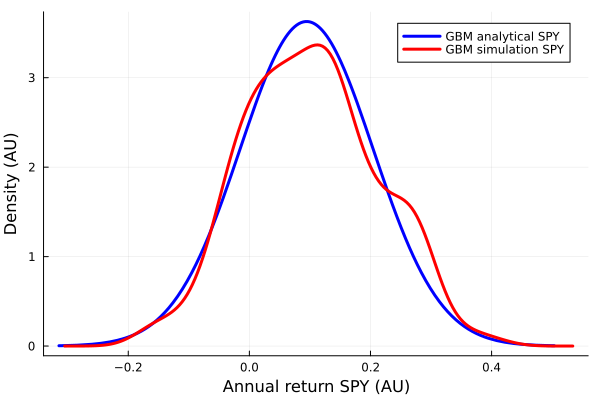

In [34]:
let
    plot(return_analytical_model, label="GBM analytical $(my_favorite_ticker)", lw=3, c=:blue)
    density!(return_numerical_model, label="GBM simulation $(my_favorite_ticker)",lw=3, c=:red)
    xlabel!("Annual return $(my_favorite_ticker) (AU)",fontsize=18)
    ylabel!("Density (AU)", fontsize=18)
end

#### Check: Are the analytical and Monte Carlo returns drawn from the same distribution?
GBM returns for firm $i$, whether calculated using the analytical solution or by Monte Carlo simulation, will always be Normally distributed. Thus, if $c_{i}\neq\text{normal}$, then the model _fails_ to capture the actual shape of the returns. However, another question is whether the analytical solution and the Monte Carlo approach produce returns from the _same distribution_. 

Let's develop an approach to answer this question using the [One-sample Anderson Darling test](https://juliastats.org/HypothesisTests.jl/stable/nonparametric/#HypothesisTests.OneSampleADTest) exported by the [HypothesisTests.jl package](https://github.com/JuliaStats/HypothesisTests.jl).
* The `H0:null hypothesis` is that the returns from the analytical model and the Monte Carlo simulation are drawn from the _same distribution_. The `H1:alternative` hypothesis is that they are drawn from different distributions. We `reject H0` if `pvalue`$\leq$`p_value_cutoff`.

In [36]:
onesample_AD_test_result = OneSampleADTest(return_numerical_model, return_analytical_model)

One sample Anderson-Darling test
--------------------------------
Population details:
    parameter of interest:   not implemented yet
    value under h_0:         NaN
    point estimate:          NaN

Test summary:
    outcome with 95% confidence: fail to reject h_0
    one-sided p-value:           0.2847

Details:
    number of observations:   396
    sample mean:              0.101439999146412
    sample SD:                0.11039793617401994
    A² statistic:             1.1564914089201148


#### Discussion questions
1. Does the `number_of_samples` influence the agreement between the analytical return distribution and the return distribution created by Monte Carlo simulations?
2. How would you develop a procedure that compares the return distribution shape if we used the [K-sample Anderson-Darling test](https://juliastats.org/HypothesisTests.jl/stable/nonparametric/#HypothesisTests.KSampleADTest) instead of the [One-sample Anderson Darling test](https://juliastats.org/HypothesisTests.jl/stable/nonparametric/#HypothesisTests.OneSampleADTest)?

### Test the autocorrelation of GBM model returns
Another important stylized fact is the lack of autocorrelation of the returns. Let's compute the autocorrelation of the _daily_ returns from the data and compare that to the _daily_ autocorrelation computed using geometric Brownian motion.
* __Hypothesis__: Geometric Brownian motion is a random walk with drift. Thus, the autocorrelation of the returns computed from a GBM model should be close to zero. On the other hand, the actual return data for `my_favorite_ticker` should also follow a random walk, suggesting stock returns are random, a key tenet of the [efficient market hypothesis](https://en.wikipedia.org/wiki/Efficient-market_hypothesis)

Let's construct the _daily_ return from the simulation array `X` and store these values in the `daily_return_array_GBM` variable, where the `T-1` rows correspond to time, and the `number_of_samples` columns hold the return values $r_{t,t-1}$ where the time step is a single trading day.

In [39]:
daily_return_array_GBM = let
    daily_return_array_GBM = Array{Float64,2}(undef, nrow(my_price_dataset)-1, number_of_samples)
    for i ∈ 1:number_of_samples
        for k ∈ 2:nrow(my_price_dataset)
            Sₒ = X[k-1,i+1];
            S₁ = X[k,i+1];
            daily_return_array_GBM[k-1,i] = log(S₁/Sₒ);
        end
    end
    daily_return_array_GBM;
end;

* Next, we can compute the _daily_ return from the observed market data using [the `log_growth_matrix(...)` method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.log_growth_matrix). We store the data in the `daily_return_array_data` array, where `daily_return_array_data` has `T-1` rows and a single column: 

In [41]:
daily_return_array_data = log_growth_matrix(Dict(my_favorite_ticker=>my_price_dataset), 
    [my_favorite_ticker], testfirm=my_favorite_ticker, Δt = 1.0) # returns *return* data

1257×1 Matrix{Float64}:
 -0.014149535079812127
  0.019307146747641335
  0.014314685231080653
  0.0070306138672558026
  0.007614367585631101
  3.0254463311407115e-5
  0.0019843217631676136
 -0.0022426777978387983
  0.0072901279577197815
  0.0060819218888377435
  0.0032341757430022545
  0.01378348979971667
 -0.010409891836026931
  ⋮
  0.009983116375516275
  0.008836465141093701
 -0.005019876416156811
  0.00532616081261946
  0.004485364980376628
 -0.004869242185085003
 -0.0009511069424693901
  0.005445999460762184
  0.0027642227708993537
  0.0013862925441834643
  0.002108667342119756
 -0.0029638570042014663

Finally, let's compute the [autocorrelation](https://en.wikipedia.org/wiki/Autocorrelation) using the [autocor function](https://juliastats.org/StatsBase.jl/stable/signalcorr/#StatsBase.autocor) exported by the [StatsBase.jl package](https://github.com/JuliaStats/StatsBase.jl). 
* First, compute the length $L$ of the data, in this case `daily_return_array_data` which should be `L = T - 1`.
* Next, we compute the lag range and store this in the `τ` variable.
* Lastly, compute the autocorrelation for the GBM model returns (stored in the `AC_model` variable) and from the observed market price (stored in the `AC_data` variable).

In [43]:
L = length(daily_return_array_data);
τ  = range(0,step=1,stop=(L-1));
AC_model = autocor(daily_return_array_GBM[:,1], τ); # function provided by the StatsBase package
AC_data = autocor(daily_return_array_data, τ); # function provided by the StatsBase package

`Unhide` the code block below to see how we visualize the autocorrelation computed from the model, and the prices observed in the market. 

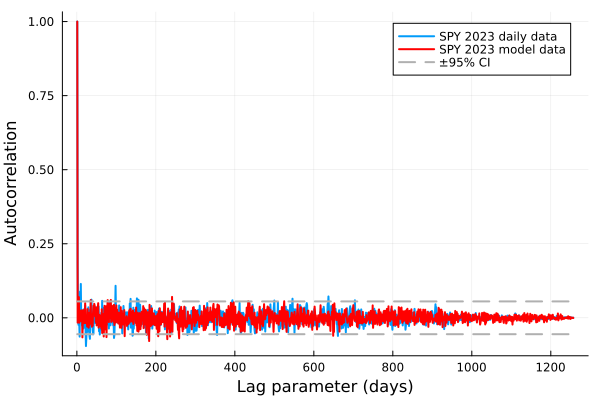

In [45]:
let
    Δ = 1.96/sqrt(L)
    plot(AC_data, lw=2, label="$(my_favorite_ticker) 2023 daily data")
    plot!(AC_model, lw=2, c=:red,label="$(my_favorite_ticker) 2023 model data")
    plot!(Δ*ones(L),lw=2,c=:gray69,ls=:dash, label="±95% CI")
    plot!(-Δ*ones(L),lw=2,c=:gray69,ls=:dash, label="")
    xlabel!("Lag parameter (days)",fontsize=18)
    ylabel!("Autocorrelation", fontsize=18)
end

### Test the volatility clustering of GBM model returns
Fill me in

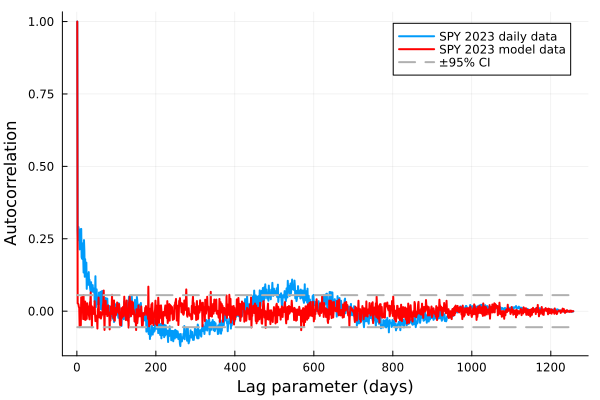

In [47]:
let
    Δ = 1.96/sqrt(L)
    VC_model = autocor(abs.(daily_return_array_GBM[:,1]), τ); # function provided by the StatsBase package
    VC_data = autocor(abs.(daily_return_array_data), τ); # function provided by the StatsBase package
    plot(VC_data, lw=2, label="$(my_favorite_ticker) 2023 daily data")
    plot!(VC_model, lw=2, c=:red,label="$(my_favorite_ticker) 2023 model data")
    plot!(Δ*ones(L),lw=2,c=:gray69,ls=:dash, label="±95% CI")
    plot!(-Δ*ones(L),lw=2,c=:gray69,ls=:dash, label="")
    xlabel!("Lag parameter (days)",fontsize=18)
    ylabel!("Autocorrelation", fontsize=18)
end

## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.